In [21]:
# import libraries
import numpy as np # linear algebra
import pandas as pd # data processing, csv file I/O
import datetime as dt

# for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# for maachine learning algorithm
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

df = pd.read_excel('Online Retail.xlsx')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [23]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [24]:
df = df.dropna(subset=['CustomerID'])
df.duplicated().sum()

5225

In [25]:
df = df.drop_duplicates()
df.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,401604.000000,401604,401604.000000,401604.000000
mean,12.183273,2011-07-10 12:08:23.848567552,3.474064,15281.160818
min,-80995.000000,2010-12-01 08:26:00,0.000000,12346.000000
25%,2.000000,2011-04-06 15:02:00,1.250000,13939.000000
50%,5.000000,2011-07-29 15:40:00,1.950000,15145.000000
75%,12.000000,2011-10-20 11:58:30,3.750000,16784.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,250.283037,NaN,69.764035,1714.006089


In [26]:
df=df[(df['Quantity']>0) & (df['UnitPrice']>0)]

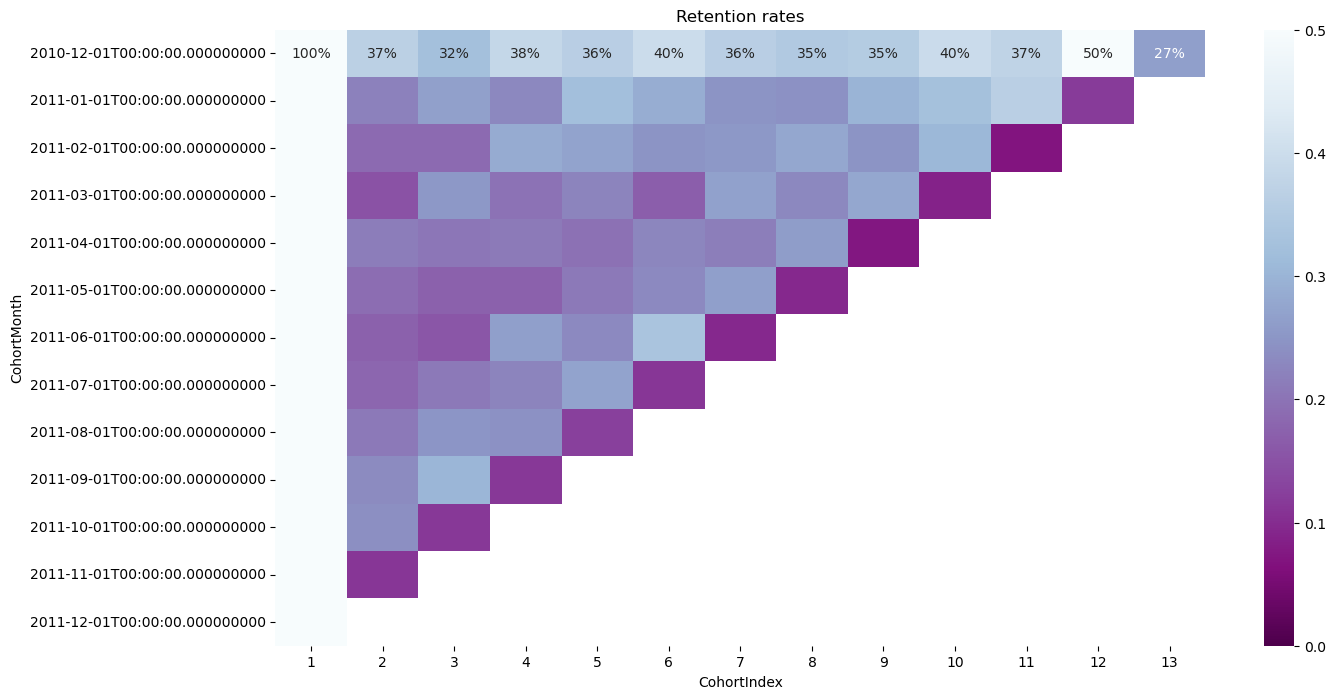

In [30]:
# data preperation for cohort analysis
# biling period
# cohort group
# cohort period / cohort index

def get_month(x) : return dt.datetime(x.year,x.month,1)
df['InvoiceMonth'] = df['InvoiceDate'].apply(get_month)
grouping = df.groupby('CustomerID')['InvoiceMonth']
df['CohortMonth'] = grouping.transform('min')

def get_month_int (dframe,column):
    year = dframe[column].dt.year
    month = dframe[column].dt.month
    day = dframe[column].dt.day
    return year, month, day

invoice_year,invoice_month,_=get_month_int(df,'InvoiceMonth')
cohort_year,cohort_month,_=get_month_int(df,'CohortMonth')

year_diff = invoice_year - cohort_year
month_diff = invoice_month - cohort_month

df['CohortIndex'] = year_diff * 12 + month_diff +1

# count monthly active customers from each cohort
grouping = df.groupby(['CohortMonth', 'CohortIndex'])
cohort_data = grouping['CustomerID'].apply(pd.Series.nunique)

# Return number of unique elements in the object
cohort_data = cohort_data.reset_index()
cohort_counts = cohort_data.pivot(index='CohortMonth',columns='CohortIndex',values='CustomerID')

# Retention table
cohort_size = cohort_counts.iloc[:,0]
retention = cohort_counts.divide(cohort_size,axis=0) #axis=0 tp ensure divide along the row axis
retention.round(3) * 100 #to show the number as percentage

#build the heatmap
plt.figure(figsize=(15,8))
plt.title('Retention rates')
sns.heatmap(data=retention,annot=True, fmt='.0%', vmin=0.0,vmax=0.5,cmap="BuPu_r")
plt.show()

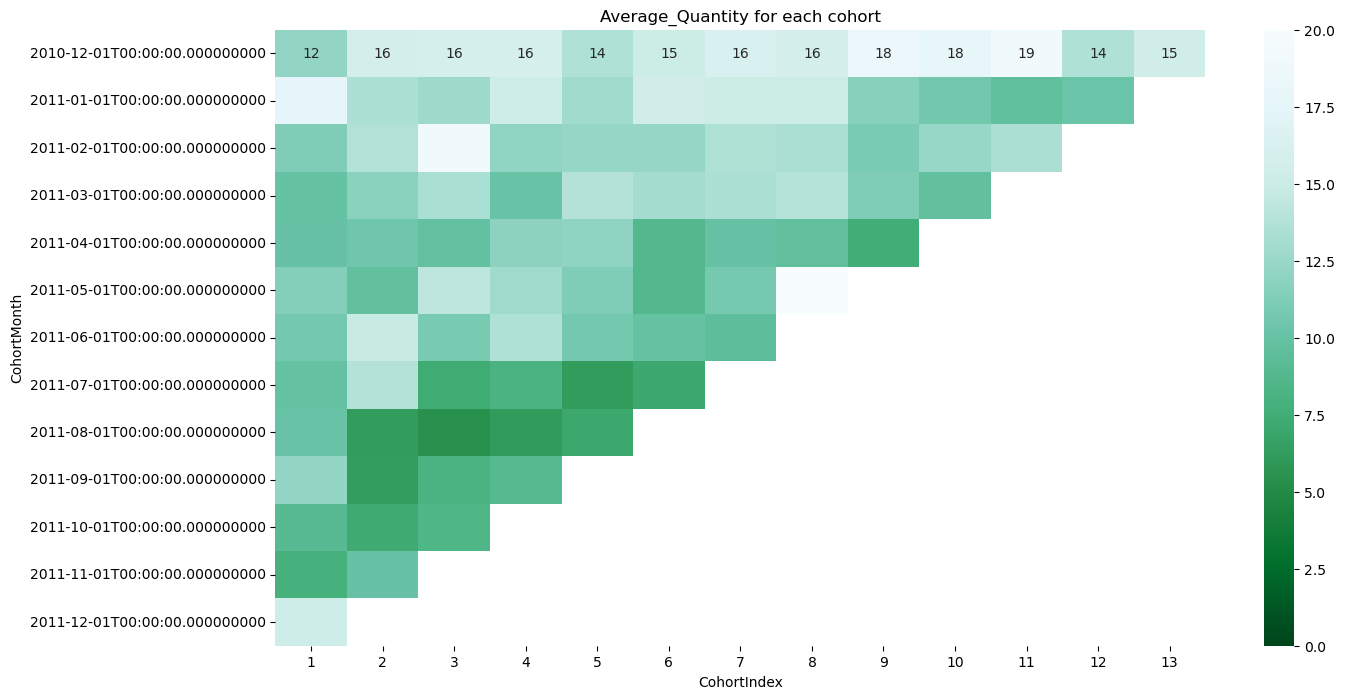

In [33]:
#Average quantity for each cohort
grouping = df.groupby(['CohortMonth','CohortIndex'])
cohort_data = grouping['Quantity'].mean()
cohort_data = cohort_data.reset_index()
average_quantity = cohort_data.pivot(index='CohortMonth',columns='CohortIndex',values='Quantity')
average_quantity.round(1)
average_quantity_index = average_quantity.index.date

# build the heatmap
plt.figure(figsize=(15,8))
plt.title('Average_Quantity for each cohort')
sns.heatmap(data=average_quantity,annot=True,vmin=0.0,vmax=20,cmap="BuGn_r")
plt.show()